In [23]:
from glob import glob
# from casatasks import importfits, imstat
import numpy as np
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
from astropy import stats
import os
from scipy.ndimage import binary_dilation  
from astropy.modeling import models, fitting
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
from regions import CircleSkyRegion, EllipseSkyRegion, Regions, RectangleSkyRegion
import numpy as np
from astropy.table import Table
import astropy.constants as ac
import astropy.units as au
from spectral_cube import SpectralCube
from astropy.io import fits
import pyregion
import os
import pickle
from tqdm.auto import tqdm 
import reproject
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import gc
from radio_beam import Beam

In [206]:
def fit_2d_gaussian_and_get_sum(image):

    image = np.squeeze(image)
    image[np.isnan(image)] = 0

    # Get the center of the image
    shape_x, shape_y = image.shape
    center_x, center_y = np.array(image.shape) // 2
    
    # Create x, y indices grid for the sub-image
    x, y = np.array(np.mgrid[:shape_x, :shape_y], dtype=np.int32)

    amplitude = np.nanmax(image)
    center_x, center_y = np.where(image==amplitude)
    
    # Initialize the Gaussian2D model
    g_init = models.Gaussian2D(amplitude=np.nanmax(image), x_mean=center_x[0], y_mean=center_y[0], x_stddev=0.3, y_stddev=0.3)
    
    # Fit the model to the sub-image
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, image)
    
    # Calculate the sum of the fitted Gaussian
    fitted_data = np.array(g(x, y))
    gaussian_sum = np.sum(fitted_data)
    
    return (gaussian_sum*u.Jy, fitted_data)

In [10]:
def get_croppeddata(hdu, position, width, height):

    # print('now', i, regions['position'][i])

    wcs = WCS(hdu)  # Create a WCS object from the HDU header
    cutout = Cutout2D(hdu.data, position, [width, height], wcs=wcs)  
    hdu_crop = fits.PrimaryHDU(cutout.data, cutout.wcs.to_header())

    del hdu 
    del cutout  # Delete the cutout to free up memory
    _ = gc.collect()  # Perform garbage collection

    return hdu_crop  # Return the cropped HDU object

In [93]:
def convert_jybeam_to_jypixel(hdu, hdu_beam):

    hdu_scaled = hdu.copy()
    
    beam = Beam.from_fits_header(hdu_beam.header)
    beam_area = beam.beamarea_equiv[0][1].to(au.sr)*au.sr
    pix_area = ((np.abs(hdu.header['CDELT1']))*au.deg)**2
    ratio_area = pix_area.to(au.sr)/beam_area.to(au.sr)
    
    hdu_scaled.data = hdu_scaled.data * ratio_area
    
    return(hdu_scaled)

In [11]:
file_cont12msd = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/misc/regrid_crop/cont_12mtp_final_filled.fits'
file_cont12m = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/misc/regrid_crop/12m_continuum_commonbeam_circular_reimaged_mosaic.fits'

hdu_cont12msd = fits.open(file_cont12msd)[0]
hdu_cont12m = fits.open(file_cont12m)[0]

In [214]:
position = SkyCoord(ra=267.0773255*au.deg, dec=-28.3301381*au.deg, frame='icrs')
radius = 0.0007184*au.deg*2

hducrop_cont12msd = get_croppeddata(hdu_cont12msd, position, radius, radius)
hducrop_cont12m = get_croppeddata(hdu_cont12m, position, radius, radius)

In [215]:
hducrop_cont12msd_scaled = convert_jybeam_to_jypixel(hducrop_cont12msd, hdu_cont12msd)
hducrop_cont12m_scaled = convert_jybeam_to_jypixel(hducrop_cont12m, hdu_cont12m)

In [216]:
fit1 = fit_2d_gaussian_and_get_sum(hducrop_cont12m_scaled.data)
fit2 = fit_2d_gaussian_and_get_sum(hducrop_cont12msd_scaled.data)

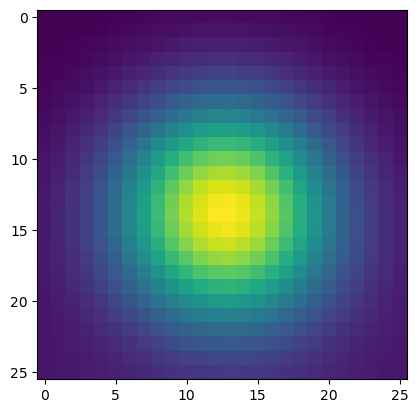

In [222]:
plt.imshow(hducrop_cont12msd_scaled.data) #, plt.imshow(fit2[1]), fit2[0]

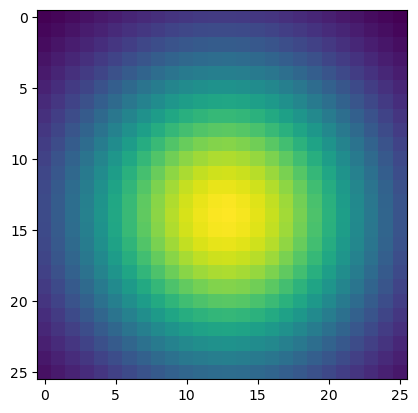

In [223]:
plt.imshow(fit2[1])